# Split the project into steps

1. Read the file
2. Remove Outliers  
   1. Quartiles
   2. Deviation **(method used)**
   3. By hand in special cases 
3. Normalization and standardization of the data
   1. Z-Score
   2. Min Max **(method used)**
4. Split the data into train, test and validation sets
5. Train the NN 
   1. KFold **(method used)**
   2. Regular train with train set, validation and test set
6. Adjust parameters

# Import libs that we'll need for the project

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from numpy import percentile
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import datetime
import matplotlib.dates as mdates
import operator
from sklearn.datasets import make_hastie_10_2
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
import joblib

#file created by us that has functions 
from funcs import * 


#just to remove the warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## Read the file and analyze data:

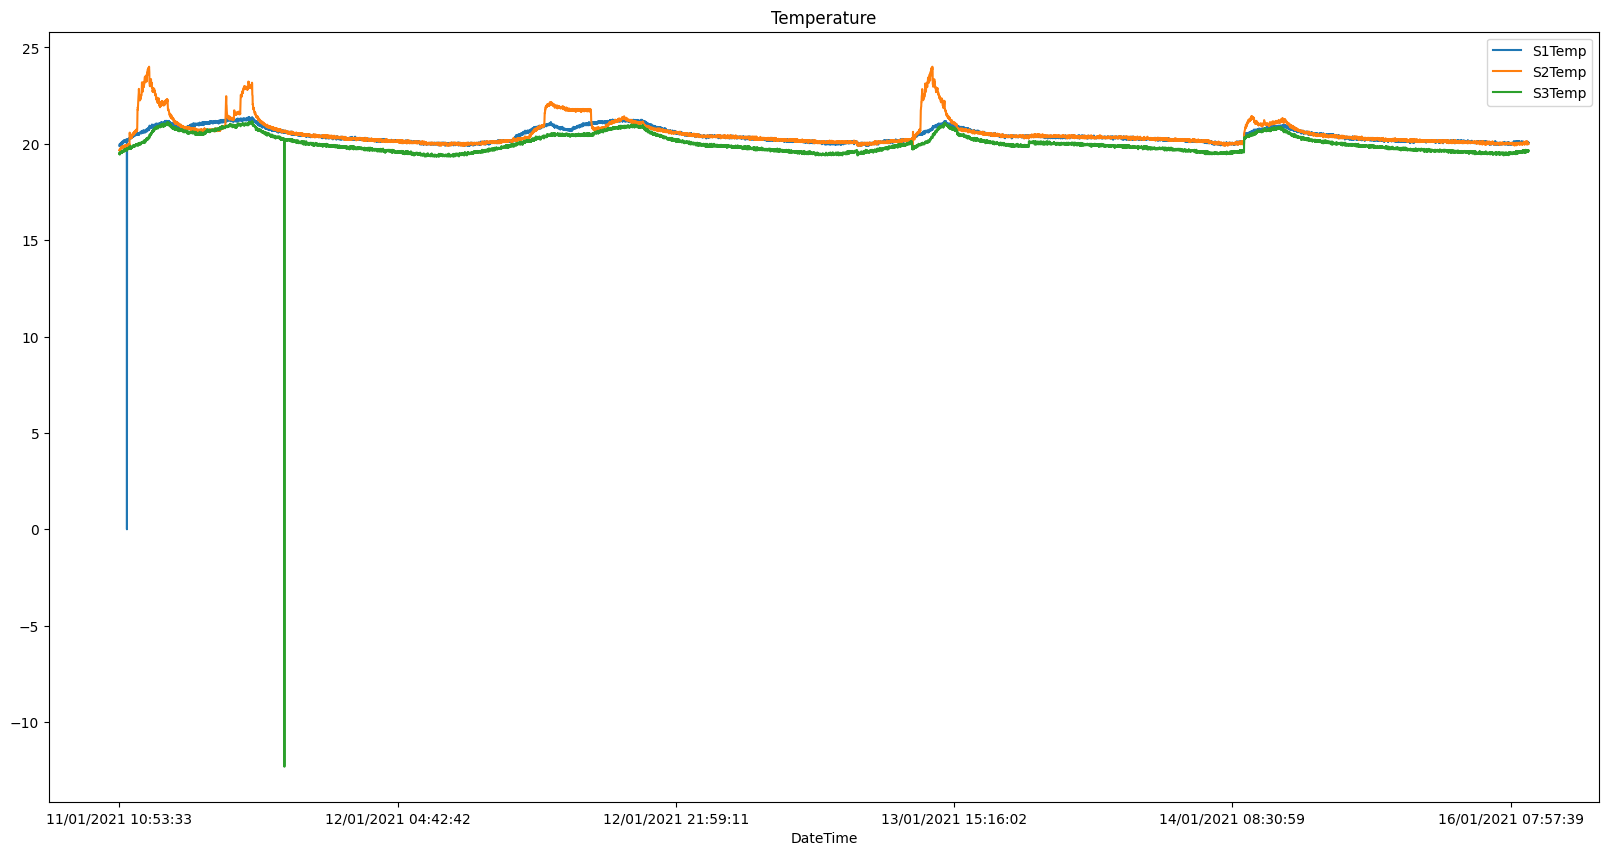

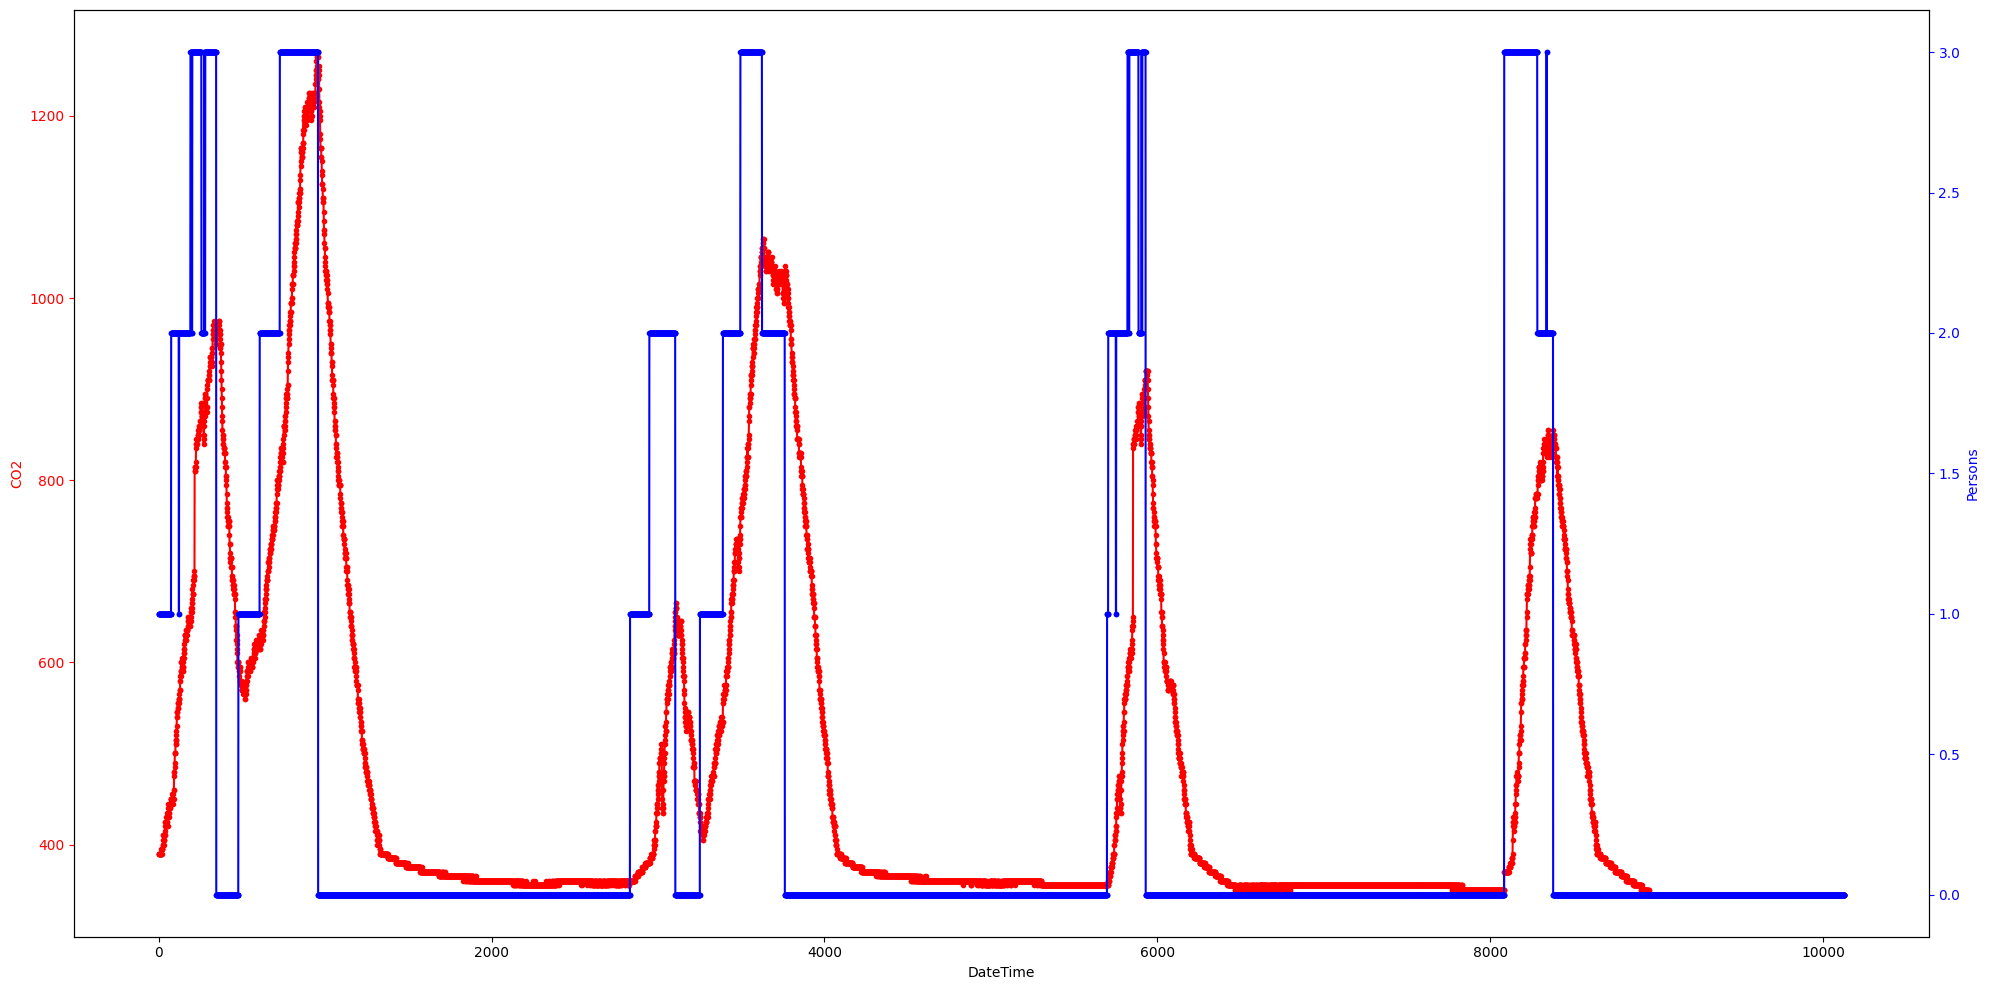

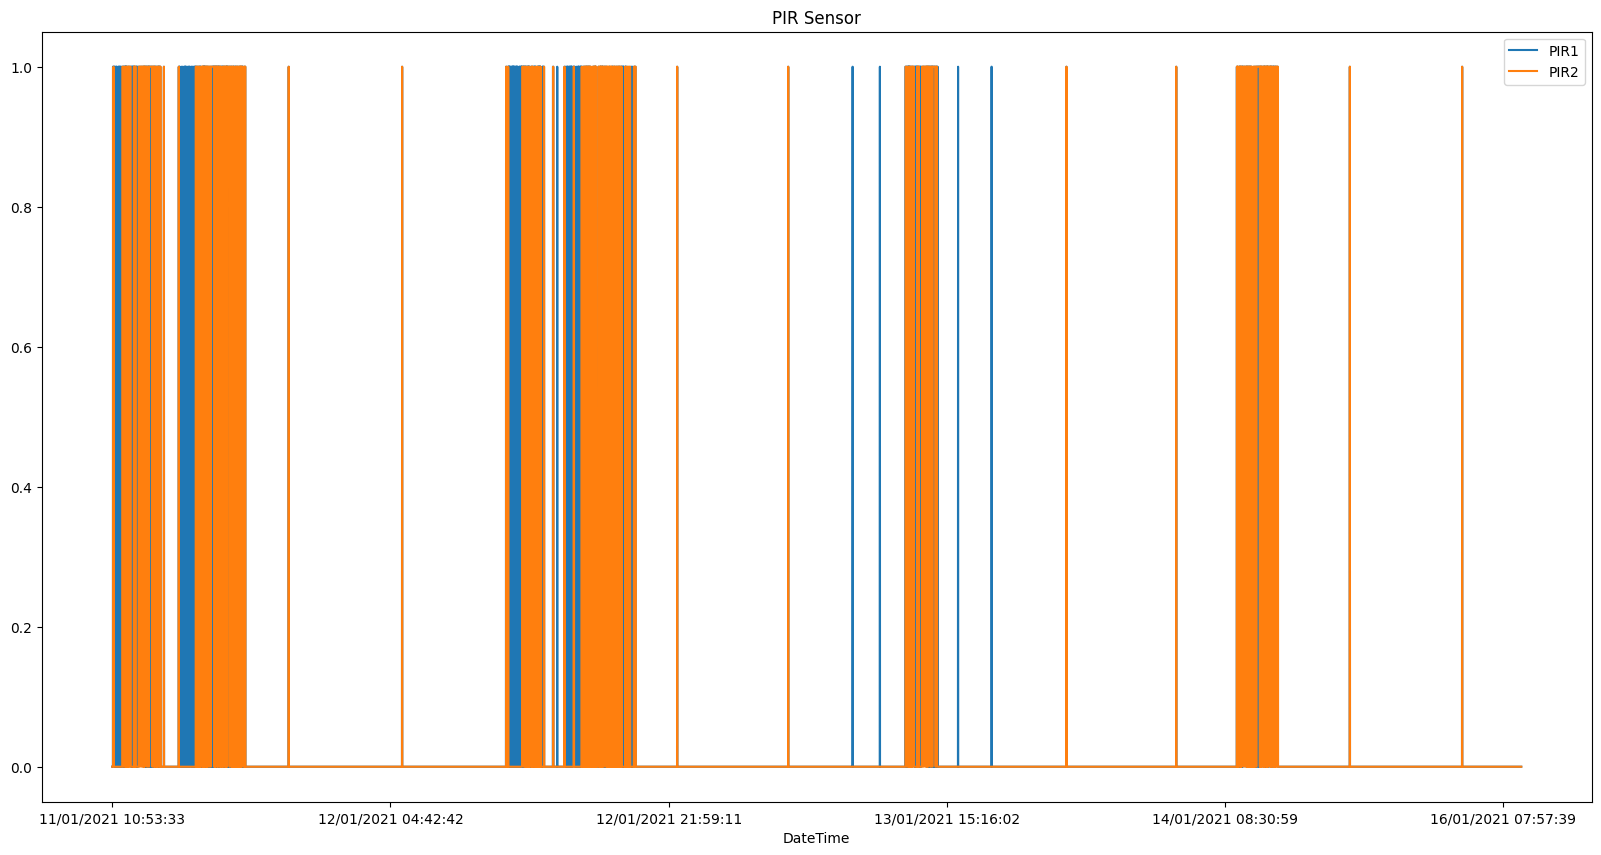

In [2]:
data_df = pd.read_csv("Proj1_Dataset.csv", sep=",", decimal=".")

data_df=parse_date_time(data_df)

data_df.to_csv("Proj1_Dataset_changed.csv")


#run to view the data
plot_data(data_df, temperature=True, CO2=True, PIR=True, light=True)
#scatter_plot(data_df, temperature=True, C02_PIR=False, light=False)

# Remove Outliers and Interpolate data


In [3]:
print(data_df.describe())

             S1Temp        S2Temp        S3Temp       S1Light       S2Light  \
count  10128.000000  10127.000000  10129.000000  10129.000000  10129.000000   
mean      20.424883     20.553337     20.003294     62.218185     58.250864   
std        0.415856      0.663691      0.543616    131.357611    142.220513   
min        0.000000     19.660000    -12.320000      0.000000      0.000000   
25%       20.130000     20.140000     19.650000      0.000000      0.000000   
50%       20.330000     20.340000     19.910000      0.000000      0.000000   
75%       20.672500     20.700000     20.310000     28.000000     30.000000   
max       21.380000     24.000000     21.180000   5500.000000    516.000000   

            S3Light           CO2          PIR1          PIR2       Persons  
count  10129.000000  10128.000000  10129.000000  10129.000000  10129.000000  
mean      80.774706    474.081754      0.107612      0.094382      0.452068  
std      661.501771    204.196690      0.309905      0

While using "describe()" we realized the following:

- The dataframe is 10129 rows long and some values return a count of, for example, 10127 rows, therefore we need to fill in the data where this values are missing 
- If we look closely to the mean and max values of each collumn we realize that there are some outliers due to the discrepancy of the values. Due to the ammount of data we'll simply drop the entire row where the value is found. 



### Drop Outliners

In [4]:
data_df = drop_outliners(data_df, threshold=6,
                         collumn_to_remove_outliers=
                         ["S1Temp", "S2Temp","S3Temp",
                          "CO2","PIR1", "PIR2","S1Light",
                           "S2Light","S3Light"])


Removed outlined from index  56 from  S1Temp with value of: 0.0
Removed outlined from index  1188 from  S3Temp with value of: -12.32
Removed outlined from index  3760 from  S1Light with value of: 5500
Removed outlined from index  2800 from  S3Light with value of: 65536


### Interpolate NaN

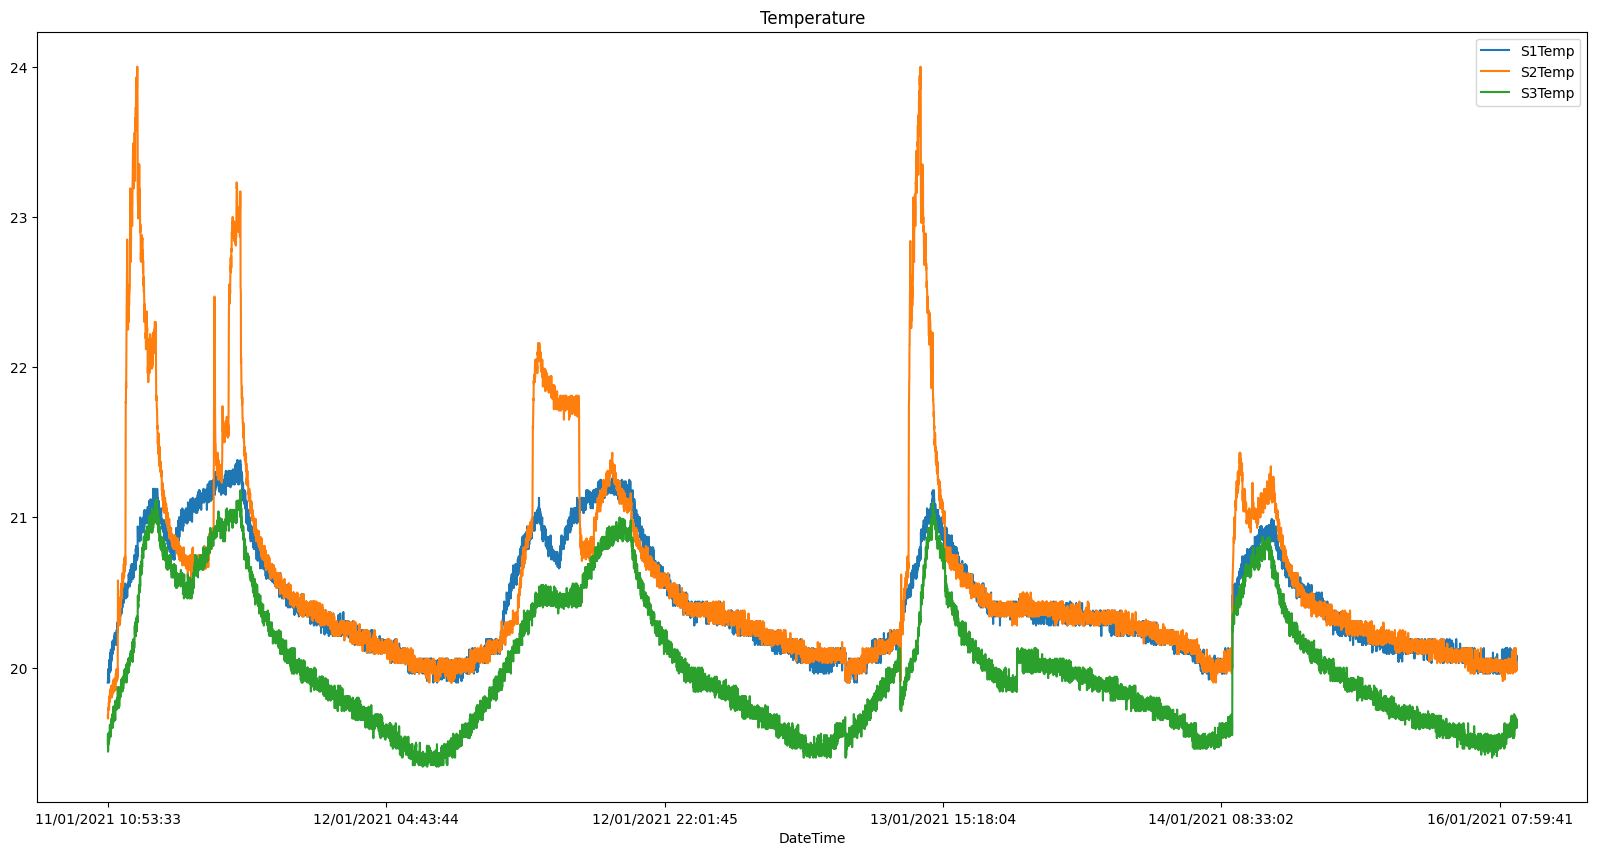

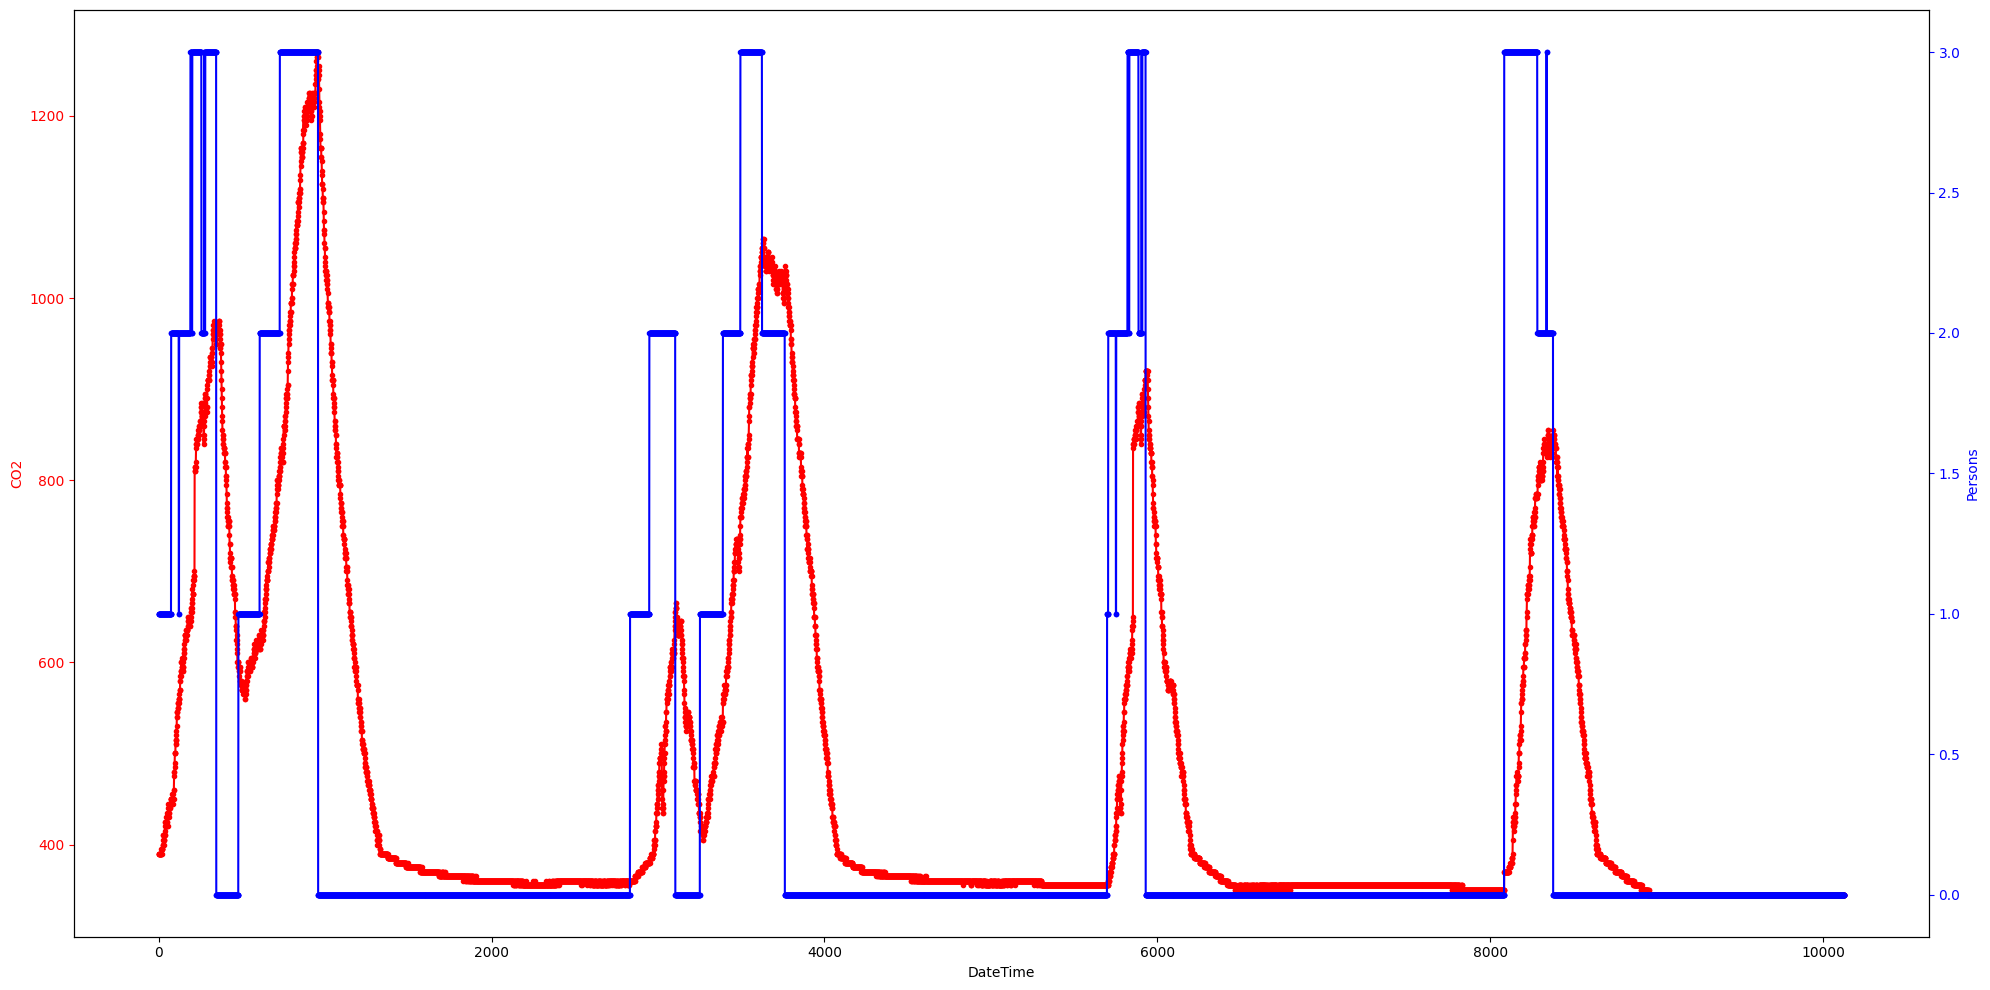

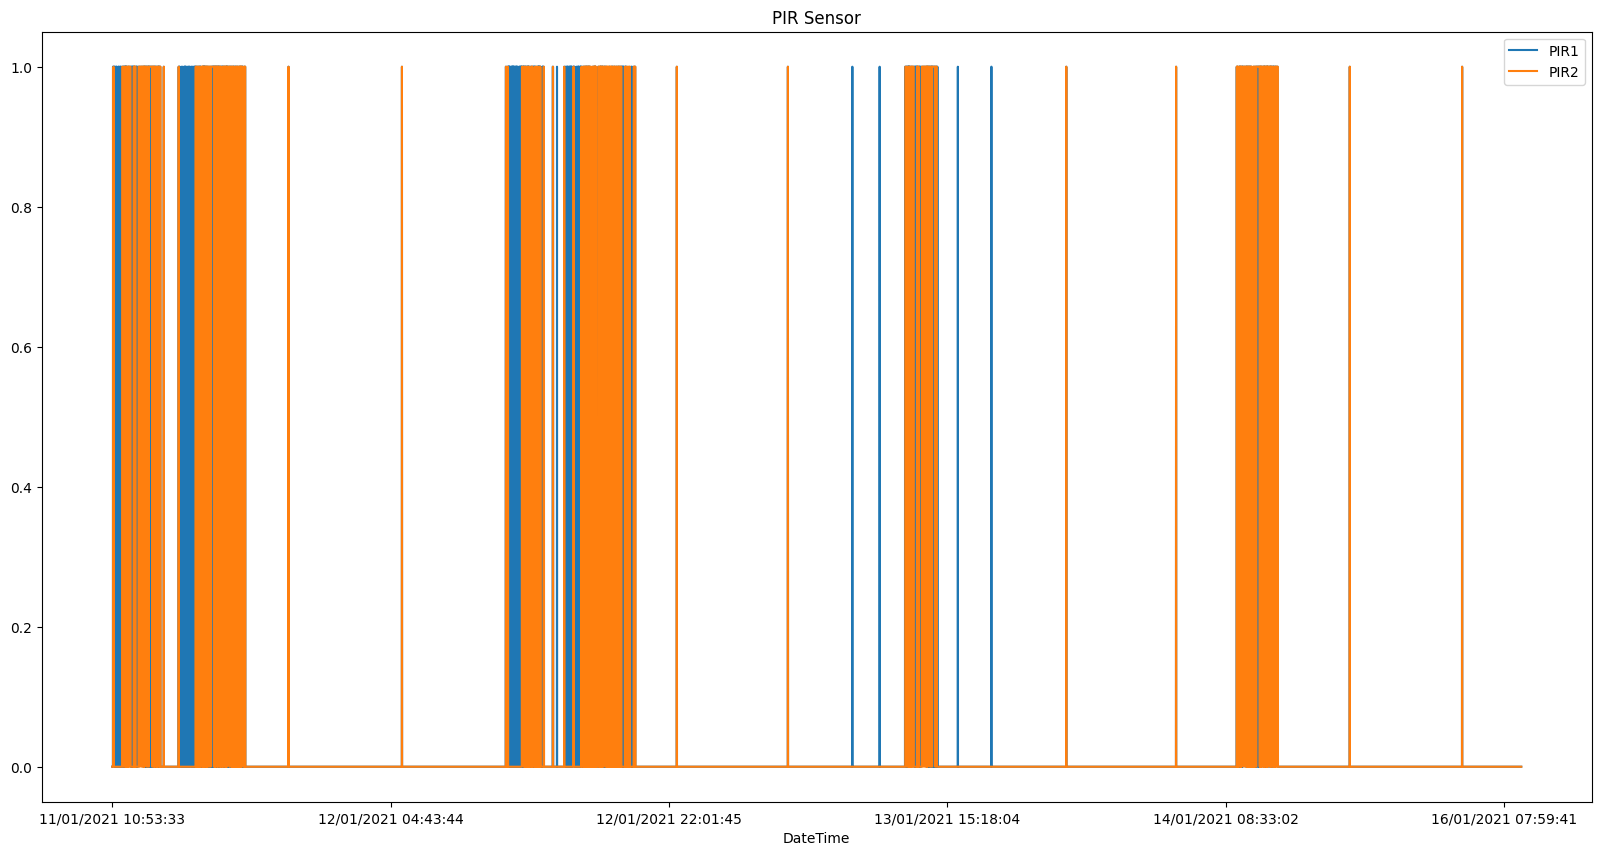

In [5]:
# interpolate NaN values
data_df = data_df.interpolate(method='linear', limit_direction='forward', axis=0)


#run to view the data with outliners removed
plot_data(data_df, temperature=True, CO2=True, PIR=True, light=True)
#scatter_plot(data_df, temperature=True, C02_PIR=False, light=False)

# Normalize data (min max method)

In [6]:
# split into train and test sets
from sklearn.model_selection import train_test_split

# split into train and test sets

train , test = train_test_split(data_df, test_size=0.3, shuffle=True, random_state=24)

test , val = train_test_split(test, test_size=0.5, shuffle=True, random_state=24)

# split into input and output 
y_train = train['Persons']
x_train = train.drop(['Persons'], axis=1)

y_test = test['Persons']
x_test = test.drop(['Persons'], axis=1)      

y_val = val['Persons']
x_val = val.drop(['Persons'], axis=1)

# Normalize data with Min Max 
x_train, x_train_min, x_train_max = normalize_train_set(x_train)
# Normalize test set with the same min and max as train set
x_test = normalize_test_set(x_test, x_train_min, x_train_max)
# Normalize validation set with the same min and max as train set
x_val = normalize_test_set(x_val, x_train_min, x_train_max)


#drop columns we don't need
x_train = x_train.drop(['DateTime'], axis=1)
x_test = x_test.drop(['DateTime'], axis=1)
x_val = x_val.drop(['DateTime'], axis=1)

# Train the NN (K-Fold method)

In [7]:
# Train scikit NN
from unittest import result
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, r2_score, f1_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold, cross_val_score



#Implementing cross validation
k = 5
kf = KFold(n_splits=k, random_state=None)
model = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=([7,5]), random_state=21, learning_rate_init=0.04)


acc_score = []
press_score = []
rec_score = []

x = x_train
y = y_train


for train_index , test_index in kf.split(x):
    x_train, kf_x_test = x.iloc[train_index,:],x.iloc[test_index,:]
    y_train , kf_y_test = y.iloc[train_index] , y.iloc[test_index]
    
    model.fit(x_train,y_train)
    pred_values = model.predict(kf_x_test)

    acc = accuracy_score(pred_values , kf_y_test)
    press = precision_score(pred_values,  kf_y_test, average='macro')
    recall = recall_score(pred_values,  kf_y_test, average='macro')
    
    acc_score.append(acc)
    press_score.append(press)
    rec_score.append(recall)
     
avg_acc_score = sum(acc_score)/k
avg_press_score = sum(press_score)/k
avg_recall_score = sum(rec_score)/k

 
print('accuracy of each fold - {}'.format(acc_score))
print('precision of each fold - {}'.format(press_score))
print('recall of each fold - {}'.format(rec_score))


print('Avg accuracy : {}'.format(avg_acc_score))
print('Avg precision : {}'.format(avg_press_score))
print('Avg recall : {}'.format(avg_recall_score))


# Predict on validation set
y_pred = model.predict(x_val)

print("\n [Validation set]")
print("Accuracy:",accuracy_score(y_val, y_pred))
print("Precision:",precision_score(y_val, y_pred, average='macro'))
print("Recall:",recall_score(y_val, y_pred, average='macro'))
print("Confusion:\n",confusion_matrix(y_val, y_pred))
print("\n")

# Predict on test set
y_pred = model.predict(x_test)
print("\n [Test set]")
print("Accuracy:",accuracy_score(y_test, y_pred))
print("Precision:",precision_score(y_test, y_pred, average='macro'))
print("Recall:",recall_score(y_test, y_pred, average='macro'))
print("Confusion:\n",confusion_matrix(y_test, y_pred))    
print("\n")




accuracy of each fold - [0.9703808180535967, 0.998589562764457, 0.9428369795342273, 0.9992942836979535, 0.9322512350035286]
precision of each fold - [0.9587162757575688, 0.9282170699605143, 0.9479400097573529, 0.49964714184897674, 0.5026625927542558]
recall of each fold - [0.9721179751379192, 0.9282170699605143, 0.9027696989986913, 0.5, 0.6503163608012474]
Avg accuracy : 0.9686705758107526
Avg precision : 0.7674366180157336
Avg recall : 0.7906842209796745

 [Validation set]
Accuracy: 0.9986833443054641
Precision: 0.5
Recall: 0.49934167215273206
Confusion:
 [[1517    2]
 [   0    0]]



 [Test set]
Accuracy: 0.8275181040157998
Precision: 0.6608768036927753
Recall: 0.4172150002674799
Confusion:
 [[1225    0    0]
 [   0   16   77]
 [ 184    1   16]]




# Export the model and min and max values (normalization)

In [8]:
#exports max and min vector to file 
np.savetxt("min.txt", x_train_min)
np.savetxt("max.txt", x_train_max)

#exports model to file
model_filename = 'model.sav'
joblib.dump(model, model_filename)


['model.sav']

# Test the model with a certain file 

In [9]:
from TestMe import *

In [10]:
TestMe("proffunc.csv")

Removed outlined from index  56 from  S1Temp with value of: 0.0
Removed outlined from index  1188 from  S3Temp with value of: -12.32
Removed outlined from index  3760 from  S1Light with value of: 5500
Removed outlined from index  2800 from  S3Light with value of: 65536


Here's the confunsion matrix obtained
[[7988    6    0    0]
 [   9  453    5    0]
 [   0    1  784   98]
 [ 184    0   87  510]]


Macro-Precision:   92.37460797763543 
Macro-Recall:      87.75405082319267 
Macro-F1:          89.77000428546845 


Precision ( 0 persons):   99.92494370778083 %
Precision ( 1 persons):   97.00214132762312 %
Precision ( 2 persons):   88.78822197055493 %
Precision ( 3 persons):   65.30089628681178 %


Recall ( 0 persons):   97.64087519863097 %
Recall ( 1 persons):   98.47826086956522 %
Recall ( 2 persons):   89.49771689497716 %
Recall ( 3 persons):   83.88157894736842 %


a) Detect when there are more than 2 persons inside the lab;

In [11]:
# Detect when there are more than 2 persons inside the lab
# new collumn crowded when there are 3 persons or more
data_df['Crowded'] = np.where(data_df['Persons'] >= 3, 1, 0)

# predict whole dataset
y_pred = model.predict(data_df.drop(['DateTime', 'Persons', 'Crowded'], axis=1))


crowded_list = []
for i in range(len(y_pred)):
    if y_pred[i] == 3:
        crowded_list.append(1)
    else:
        crowded_list.append(0)

data_df['Crowded_pred'] = crowded_list

data_df.to_csv('data_crowd.csv')

# confusion matrix for crowded
print("Confusion:\n",confusion_matrix(data_df['Crowded'],crowded_list))


Confusion:
 [[ 798   49]
 [8546  732]]
